In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 105)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

In [2]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for SalePrice and features     
use_logvals = 1    
# target used for correlation 
target = 'SalePrice_Log'
    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4    
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

<b> Some functions</b>

In [3]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [4]:
def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

In [5]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [6]:
# Loading data
df_train= pd.read_csv('C:/Users/Mayank/Downloads/house-prices-advanced-regression-techniques/train.csv')
df_test=pd.read_csv('C:/Users/Mayank/Downloads/house-prices-advanced-regression-techniques/test.csv')

In [7]:
print(df_train.shape)
print("*"*50)
print(df_test.shape)

(1460, 81)
**************************************************
(1459, 80)


In [8]:
print(df_train.info())
print("*"*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Skewness: 1.882876
Kurtosis: 6.536282


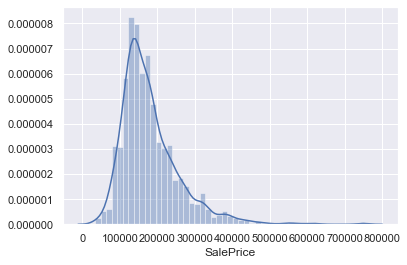

In [9]:
sns.distplot(df_train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

<b>As we see, the target variable SalePrice is not normally distributed.
This can reduce the performance of the ML regression models because some assume normal distribution,
see sklearn info on preprocessing
Therfore we make a log transformation, the resulting distribution looks much better.</b>

Skewness: 0.121335
Kurtosis: 0.809532


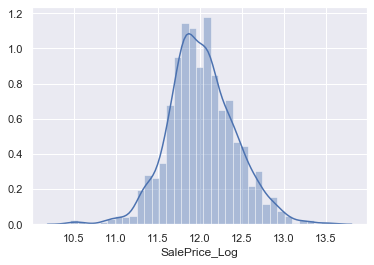

In [10]:
df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])

sns.distplot(df_train['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())
# dropping old column
df_train.drop('SalePrice', axis= 1, inplace=True)

<b> Different numerical and categorical features</b>

In [11]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


In [13]:
print(df_train[numerical_feats].columns)
print("*"*100)
print(df_train[categorical_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice_Log'],
      dtype='object')
****************************************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Founda

In [14]:
# Finding thr missing values
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [15]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

In [16]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
SalePrice_Log,0,0.000000
ExterCond,0,0.000000


In [17]:
# fillna with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [18]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)


,Total,Percent
SalePrice_Log,0,0.0
Heating,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


log transform<br>
Like the target variable, also some of the feature values are not normally distributed and it is therefore better to use log values in df_train and df_test. Checking for skewness and kurtosis:

In [19]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())  
         )

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.38     Kurtosis: 021.85
LotArea         Skewness: 12.21     Kurtosis: 203.24
OverallQual     Skewness: 00.22     Kurtosis: 000.10
OverallCond     Skewness: 00.69     Kurtosis: 001.11
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.27
MasVnrArea      Skewness: 02.68     Kurtosis: 010.15
BsmtFinSF1      Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26     Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52     Kurtosis: 013.25
1stFlrSF        Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01     Kurtosis: 083.23
GrLivArea       Skewness: 01.37     Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10     Kurtosis: 

Skewness: 1.366560
Kurtosis: 4.895121


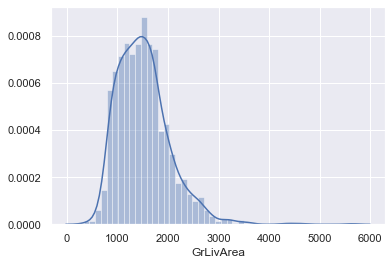

In [20]:
sns.distplot(df_train['GrLivArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

Skewness: 12.207688
Kurtosis: 203.243271


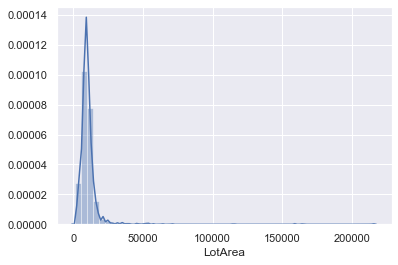

In [21]:
sns.distplot(df_train['LotArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea'].skew())
print("Kurtosis: %f" % df_train['LotArea'].kurt())

In [22]:
for df in [df_train, df_test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
    
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

Skewness: -0.006995
Kurtosis: 0.282603


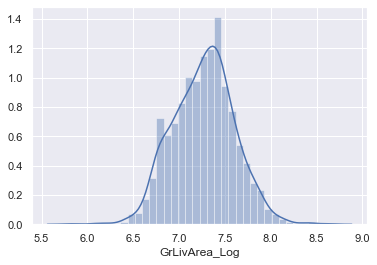

In [23]:
sns.distplot(df_train['GrLivArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea_Log'].skew())
print("Kurtosis: %f" % df_train['GrLivArea_Log'].kurt())

Skewness: -0.137994
Kurtosis: 4.713358


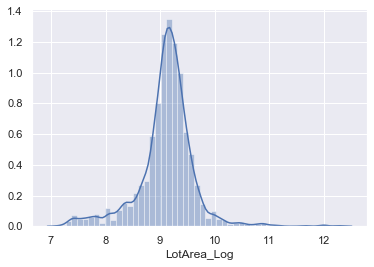

In [24]:
sns.distplot(df_train['LotArea_Log']);
#skewness and kurtosis
print("Skewness: %f" % df_train['LotArea_Log'].skew())
print("Kurtosis: %f" % df_train['LotArea_Log'].kurt())

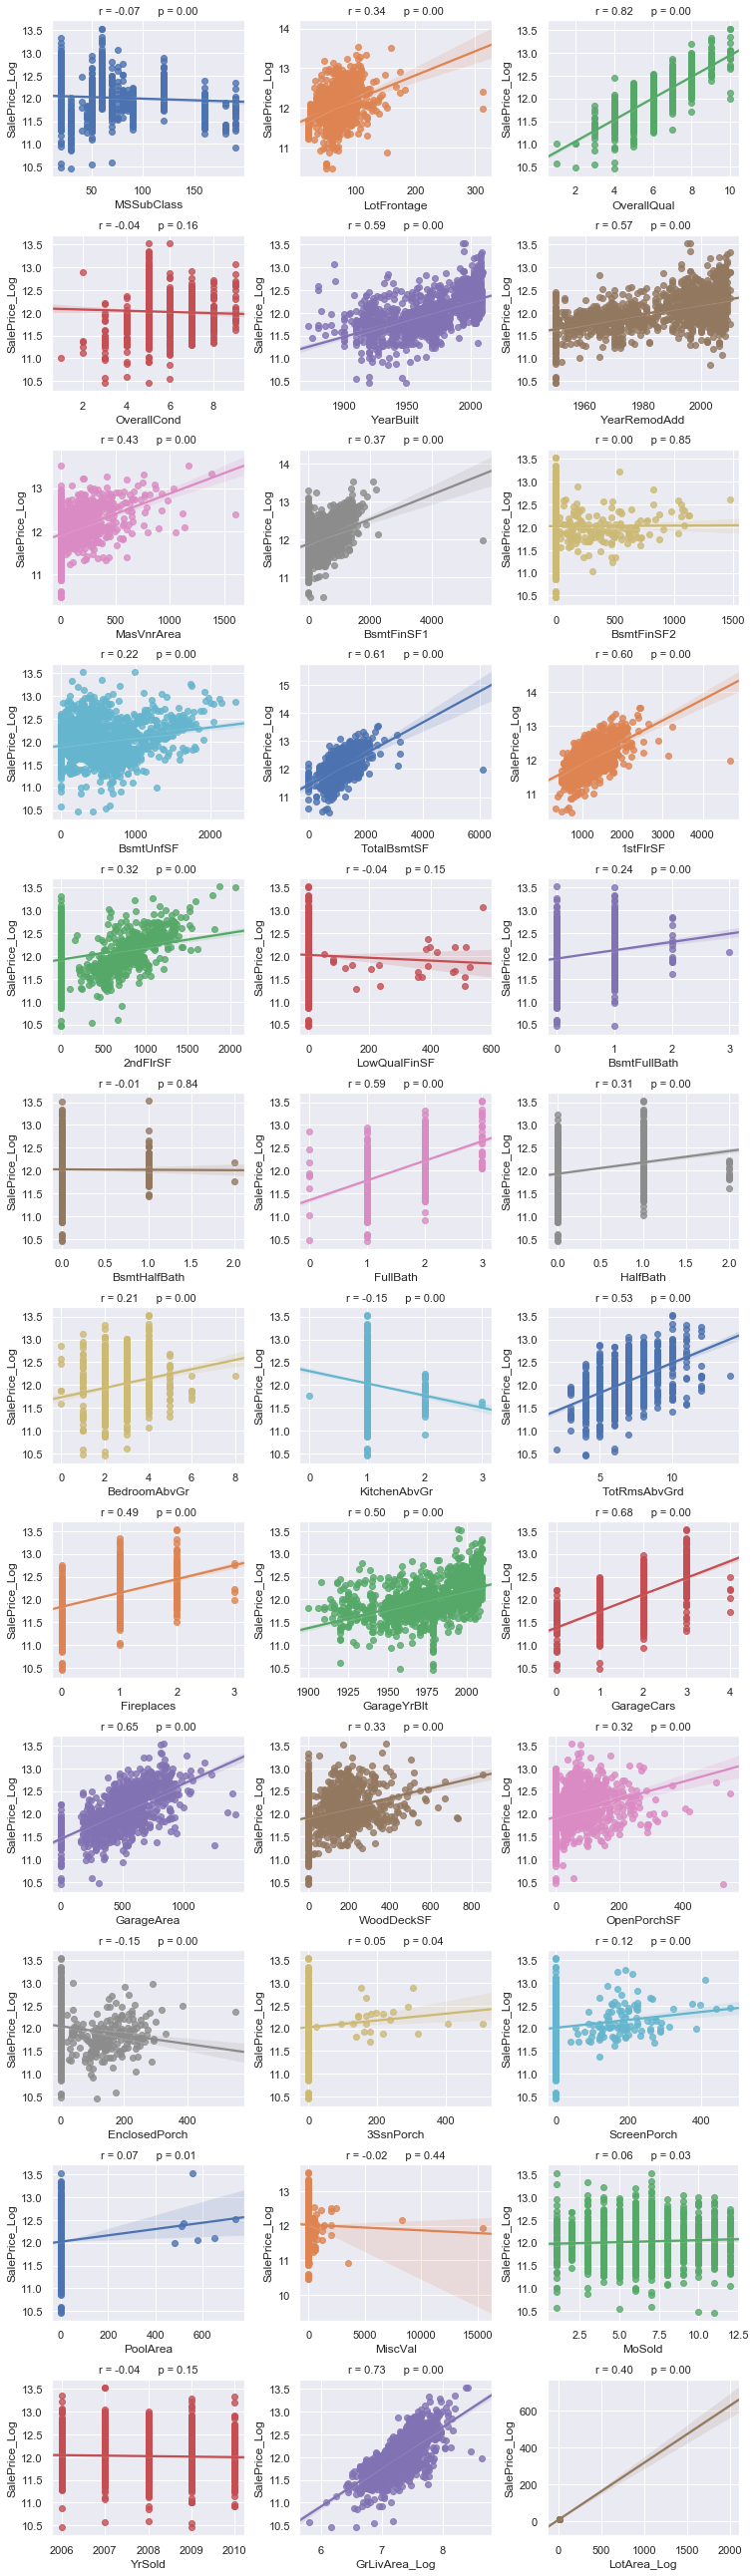

In [27]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]
for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   



Conclusion from EDA on numerical columns:

We see that for some features like 'OverallQual' there is a strong linear correlation (0.79) to the target.
For other features like 'MSSubClass' the correlation is very weak.
For this kernel I decided to use only those features for prediction that have a correlation larger than a threshold value to SalePrice.
This threshold value can be choosen in the global settings : min_val_corr

With the default threshold for min_val_corr = 0.4, these features are dropped in Part 2, Data Wrangling:
'Id', 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'

We also see that the entries for some of the numerical columns are in fact categorical values.
For example, the numbers for 'OverallQual' and 'MSSubClass' represent a certain group for that feature ( see data description txt)

In [28]:
df_train = df_train.drop(
    df_train[(df_train['OverallQual']==10) & (df_train['SalePrice_Log']<12.3)].index)
df_train = df_train.drop(
    df_train[(df_train['GrLivArea_Log']>8.3) & (df_train['SalePrice_Log']<12.5)].index)

Find columns with strong correlation to target
Only those with r > min_val_corr are used in the ML Regressors in Part 3
The value for min_val_corr can be chosen in global settings

In [29]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [30]:
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('#'*50)

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1452
Grvl       6
Name: Street, dtype: int64
##################################################
None    1367
Grvl      50
Pave      41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    483
IR2     41
IR3      9
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      61
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1051
Corner      262
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1380
Mod      65
Sev      13
Name: LandSlope, dtype: int64
###########################

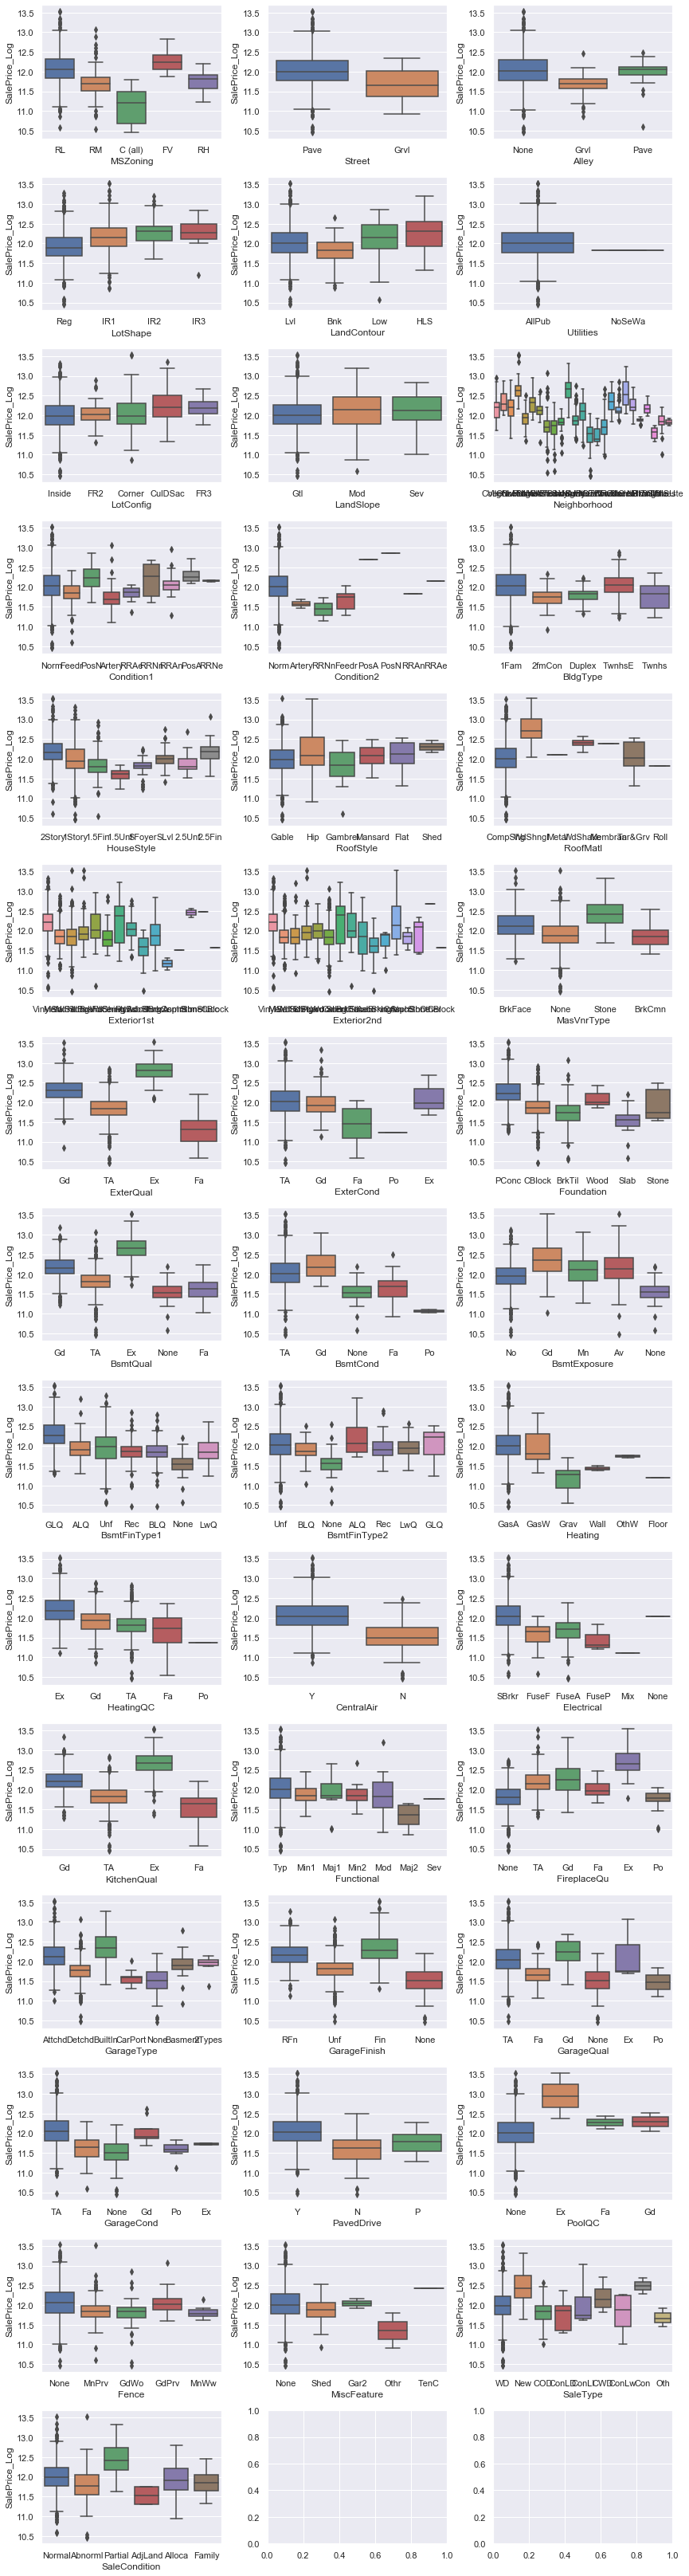

In [31]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()  

In [32]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]
      

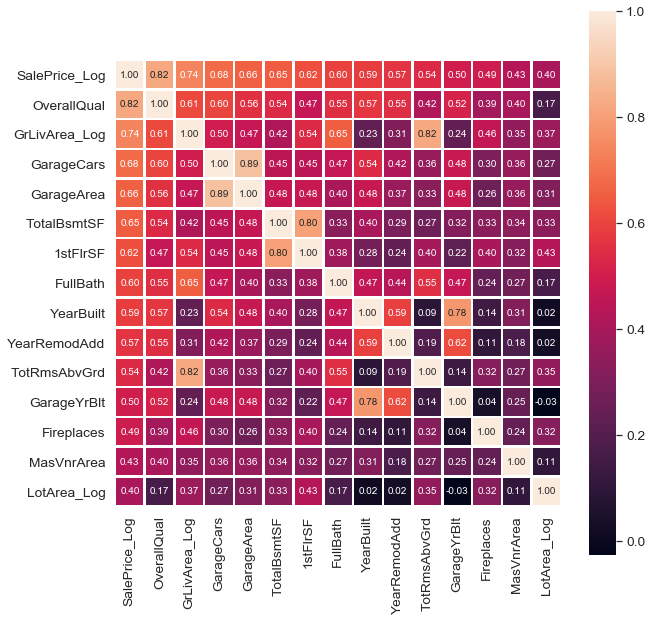

In [33]:
nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df_train, nr_feats, target)

In [34]:
id_test = df_test['Id']

to_drop_num  = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)

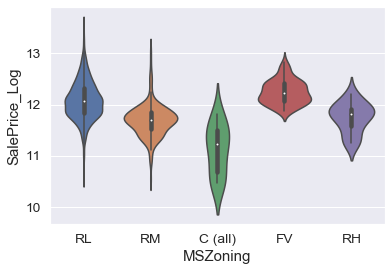

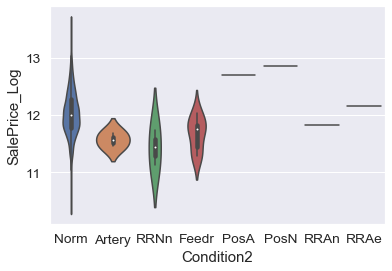

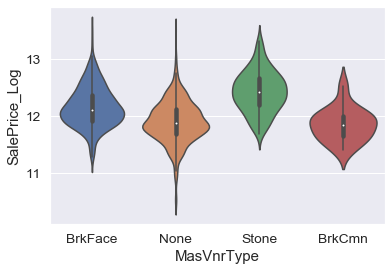

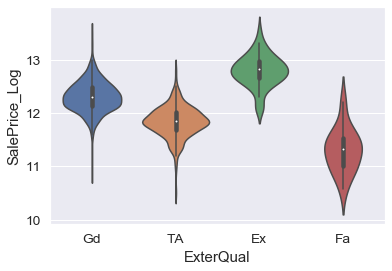

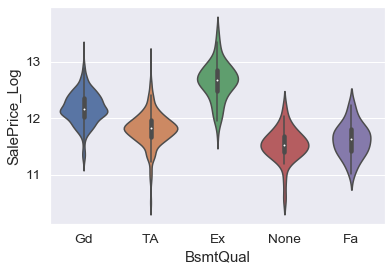

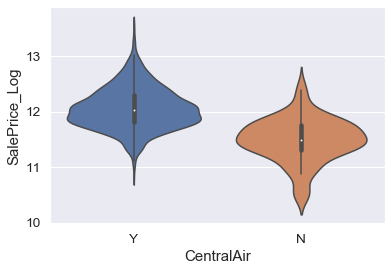

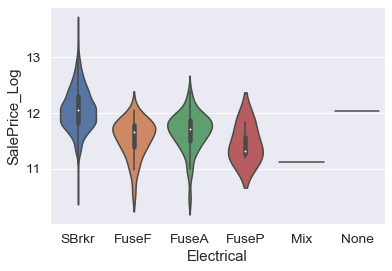

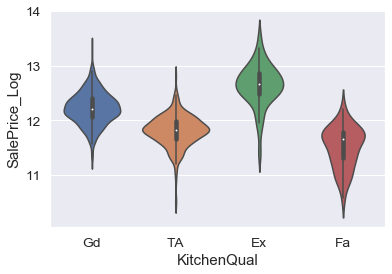

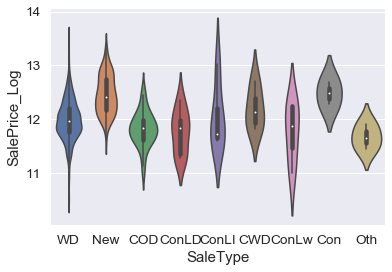

In [35]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list :
    #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()
    #sns.boxenplot(x=catg, y=target, data=df_train)
    #bp = df_train.boxplot(column=[target], by=catg)

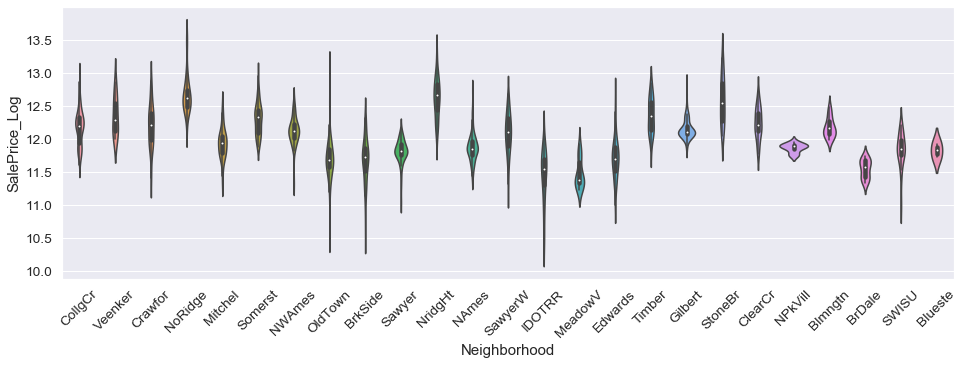

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=target, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [37]:
for catg in catg_list :
    g = df_train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085939
RM         11.692893
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025925
PosA      12.691580
PosN      12.860999
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.431016
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.792412
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.650235
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491858
Y    12.061099
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061474
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.645425
F

In [38]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']


#[]

In [39]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4  

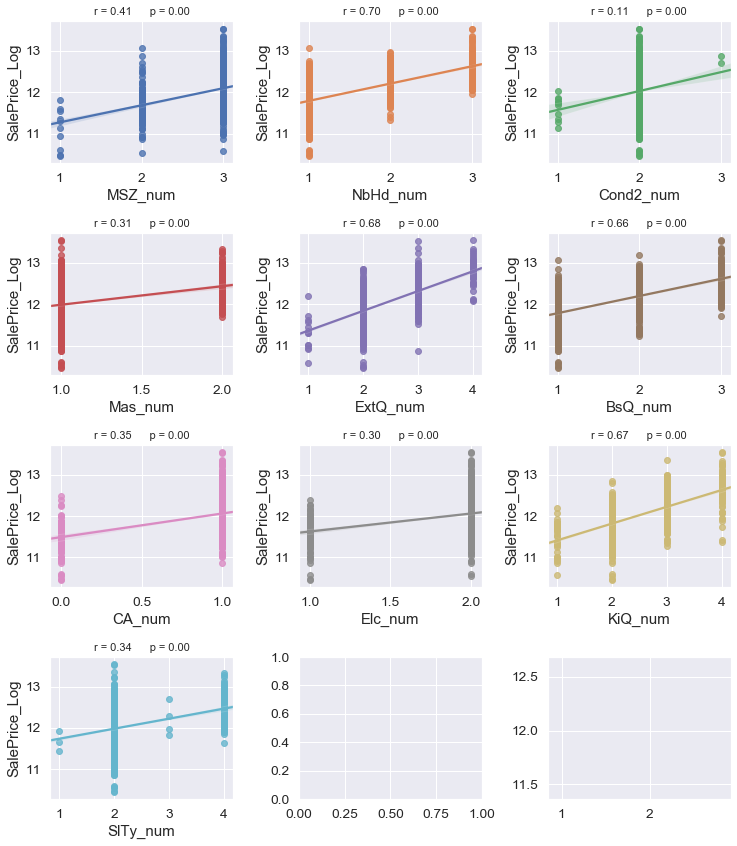

In [40]:
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

In [41]:
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)


for df in [df_train, df_test] :
    df.drop(catg_cols_to_drop, inplace= True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)    

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
CA_num           0.351598
SlTy_num         0.337469
Mas_num          0.313280
Elc_num          0.304857
Cond2_num        0.107610
Name: SalePrice_Log, dtype: float64


In [42]:
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


In [43]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print (corr_abs.nlargest(nr_all_cols, target)[target])

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
MSZ_num          0.409423
LotArea_Log      0.402814
Name: SalePrice_Log, dtype: float64


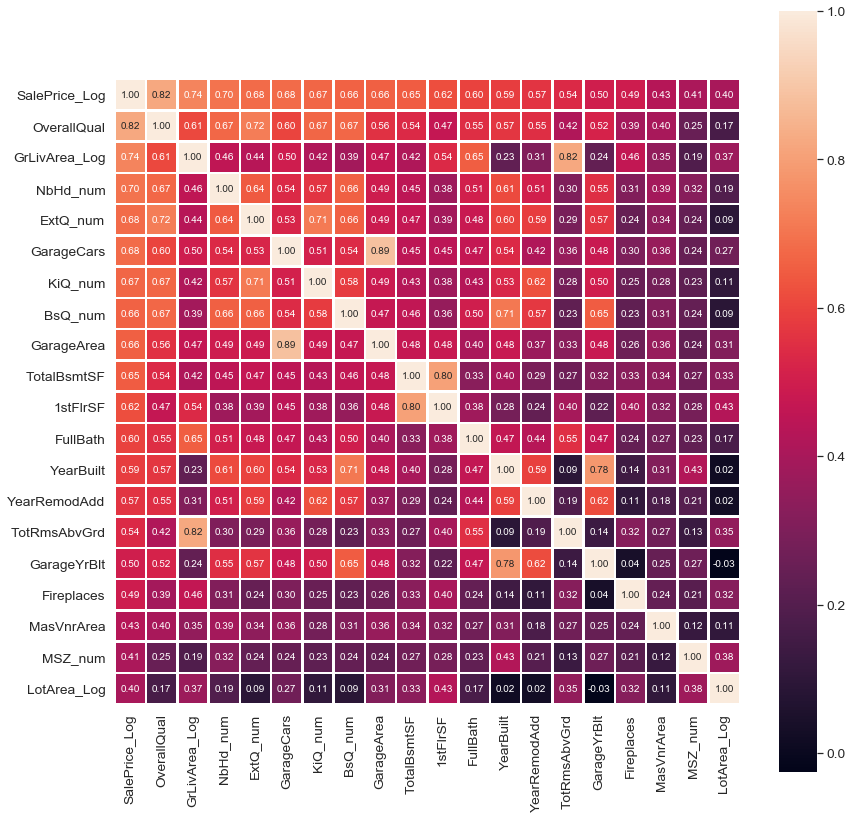

In [44]:
nr_feats=len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target)

In [45]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [46]:
cols = list(cols)
print(cols)

['SalePrice_Log', 'OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


In [47]:
feats = cols.copy()
feats.remove('SalePrice_Log')

print(feats)

['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num', 'LotArea_Log']


In [48]:
df_train_ml = df_train[feats].copy()
df_test_ml  = df_test[feats].copy()

y = df_train[target]

In [49]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [50]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,0.648281,-0.473766,0.793546,1.052959,0.880362,-0.952231,0.521228,0.438861,-0.129585
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.648281,0.504925,0.793546,0.158428,-0.428115,0.605965,-0.574433,0.438861,0.118848
2,0.658506,0.671287,0.658963,1.061109,0.313159,0.741127,0.648281,-0.319490,0.793546,0.986698,0.831900,0.605965,0.331164,0.438861,0.427653
3,0.658506,0.551993,0.658963,-0.689001,1.652119,0.741127,-0.921808,-0.714823,-1.025620,-1.862551,-0.718888,0.605965,-0.574433,0.438861,0.108680
4,1.385305,1.299759,2.162512,1.061109,1.652119,0.741127,0.648281,0.222888,0.793546,0.953567,0.734975,0.605965,1.382104,0.438861,0.889271


In [51]:
X = df_train_ml.copy()
y = df_train[target]
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]
X_test_sc = df_test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 15 columns):
OverallQual      1458 non-null int64
GrLivArea_Log    1458 non-null float64
NbHd_num         1458 non-null int64
ExtQ_num         1458 non-null int64
GarageCars       1458 non-null int64
KiQ_num          1458 non-null int64
BsQ_num          1458 non-null int64
TotalBsmtSF      1458 non-null int64
FullBath         1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
Fireplaces       1458 non-null int64
MasVnrArea       1458 non-null float64
MSZ_num          1458 non-null int64
LotArea_Log      1458 non-null float64
dtypes: float64(3), int64(12)
memory usage: 182.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 15 columns):
OverallQual      1459 non-null int64
GrLivArea_Log    1459 non-null float64
NbHd_num         1459 non-null int64
ExtQ_num         1459 non-null int64
GarageCars       1459 

In [52]:
X.head()

,OverallQual,GrLivArea_Log,NbHd_num,ExtQ_num,GarageCars,KiQ_num,BsQ_num,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Fireplaces,MasVnrArea,MSZ_num,LotArea_Log
0,7,7.444249,2,3,2,3,2,856,2,2003,2003,0,196.0,3,9.041922
1,6,7.140453,2,2,2,2,2,1262,2,1976,1976,1,0.0,3,9.169518
2,7,7.487734,2,3,2,3,2,920,2,2001,2002,1,162.0,3,9.328123
3,7,7.448334,2,2,3,3,1,756,1,1915,1970,1,0.0,3,9.164296
4,8,7.695303,3,3,3,3,2,1145,2,2000,2000,1,350.0,3,9.565214


In [54]:
X_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,0.648281,-0.473766,0.793546,1.052959,0.880362,-0.952231,0.521228,0.438861,-0.129585
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.648281,0.504925,0.793546,0.158428,-0.428115,0.605965,-0.574433,0.438861,0.118848
2,0.658506,0.671287,0.658963,1.061109,0.313159,0.741127,0.648281,-0.319490,0.793546,0.986698,0.831900,0.605965,0.331164,0.438861,0.427653
3,0.658506,0.551993,0.658963,-0.689001,1.652119,0.741127,-0.921808,-0.714823,-1.025620,-1.862551,-0.718888,0.605965,-0.574433,0.438861,0.108680
4,1.385305,1.299759,2.162512,1.061109,1.652119,0.741127,0.648281,0.222888,0.793546,0.953567,0.734975,0.605965,1.382104,0.438861,0.889271


In [55]:
X_test.head()

,OverallQual,GrLivArea_Log,NbHd_num,ExtQ_num,GarageCars,KiQ_num,BsQ_num,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Fireplaces,MasVnrArea,MSZ_num,LotArea_Log
0,5,6.797940,1,2,1.0,2,1,882.0,1,1961,1961,0,0.0,2,9.360655
1,6,7.192182,1,2,1.0,3,1,1329.0,1,1958,1958,0,108.0,3,9.565704
2,5,7.395722,2,2,2.0,2,2,928.0,2,1997,1998,1,0.0,3,9.534595
3,6,7.380256,2,2,2.0,3,1,926.0,2,1998,1998,1,20.0,3,9.208138
4,8,7.154615,3,3,2.0,3,2,1280.0,2,1992,1992,0,0.0,3,8.518193


In [56]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

In [57]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.1362343506167212
{'copy_X': True, 'fit_intercept': True, 'normalize': False}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


In [58]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear_sc.fit(X_sc, y)

sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.136234350616722
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


In [59]:
linregr_all = LinearRegression()
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [77]:
sub_linreg = pd.DataFrame()
sub_linreg['Id'] = id_test
sub_linreg['SalePrice'] = pred_linreg_all
sub_linreg.to_csv('linreg.csv',index=False)

In [61]:
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge.fit(X, y)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.13620838899929935
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-06)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.7s finished


In [62]:
ridge_sc = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge_sc = GridSearchCV(ridge_sc, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge_sc.fit(X_sc, y)

sc_ridge_sc = get_best_score(grid_ridge_sc)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.1362083889992993
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-06)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.2s finished


In [63]:
pred_ridge_all = grid_ridge.predict(X_test)

In [64]:
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_lasso.fit(X, y)

sc_lasso = get_best_score(grid_lasso)

pred_lasso = grid_lasso.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.13645673682732312
{'alpha': 0.001, 'normalize': False, 'tol': 0.0001}
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    2.7s finished


In [65]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_enet.fit(X_sc, y_sc)

sc_enet = get_best_score(grid_enet)

pred_enet = grid_enet.predict(X_test_sc)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.1371858062687302
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.01}
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.04,
           max_iter=1000000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.01, warm_start=False)


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    2.0s finished


In [66]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_sgd.fit(X_sc, y_sc)

sc_sgd = get_best_score(grid_sgd)

pred_sgd = grid_sgd.predict(X_test_sc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


0.1373839392397902
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.01,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=10000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [67]:
from sklearn.tree import DecisionTreeRegressor

param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True] , 'random_state': [5] }
            
grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_dtree.fit(X, y)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(X_test)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.18299182249476628
{'max_depth': 8, 'max_features': 14, 'max_leaf_nodes': None, 'min_samples_split': 20, 'presort': False, 'random_state': 5}
DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=14,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=5, splitter='best')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   21.5s finished


In [68]:
dtree_pred = grid_dtree.predict(X_test)
sub_dtree = pd.DataFrame()
sub_dtree['Id'] = id_test
sub_dtree['SalePrice'] = dtree_pred
#sub_dtree.to_csv('dtreeregr.csv',index=False)

In [69]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   19.2s finished


0.1465978663015509
{'min_samples_split': 4, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=5, verbose=0,
                      warm_start=False)


In [70]:
pred_rf = grid_rf.predict(X_test)

sub_rf = pd.DataFrame()
sub_rf['Id'] = id_test
sub_rf['SalePrice'] = pred_rf 

if use_logvals == 1:
    sub_rf['SalePrice'] = np.exp(sub_rf['SalePrice']) 

sub_rf.to_csv('rf.csv',index=False)

In [71]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_sc, y_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.15615217437688825
{'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.4s finished


In [72]:
pred_knn = grid_knn.predict(X_test_sc)

sub_knn = pd.DataFrame()
sub_knn['Id'] = id_test
sub_knn['SalePrice'] = pred_knn

if use_logvals == 1:
    sub_knn['SalePrice'] = np.exp(sub_knn['SalePrice']) 

sub_knn.to_csv('knn.csv',index=False)


In [73]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel

gpr = GaussianProcessRegressor(random_state=5, alpha=5e-9, 
                                n_restarts_optimizer=0, 
                               optimizer='fmin_l_bfgs_b', 
                               copy_X_train=True)

param_grid = {'normalize_y' : [True,False],
              'kernel' : [DotProduct(), ConstantKernel(1.0, (1e-3, 1e3))] }

grid_gpr = GridSearchCV(gpr, param_grid, cv=nr_cv, verbose=1, scoring = score_calc)
grid_gpr.fit(X_sc, y_sc)

sc_gpr = get_best_score(grid_gpr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Mayank\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6832.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   58.8s finished


0.1362343565302402
{'kernel': DotProduct(sigma_0=1), 'normalize_y': False}
GaussianProcessRegressor(alpha=5e-09, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=5)


In [74]:
pred_gpr = grid_gpr.predict(X_test_sc)

sub_gpr = pd.DataFrame()
sub_gpr['Id'] = id_test
sub_gpr['SalePrice'] = pred_gpr

if use_logvals == 1:
    sub_gpr['SalePrice'] = np.exp(sub_gpr['SalePrice']) 

sub_gpr.to_csv('gpr.csv',index=False)


In [75]:
list_scores = [sc_linear, sc_ridge, sc_lasso, sc_enet,
               sc_sgd, sc_dtree, sc_rf, sc_knn, sc_gpr]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','SGD','DTr','RF','KNN','GPR']

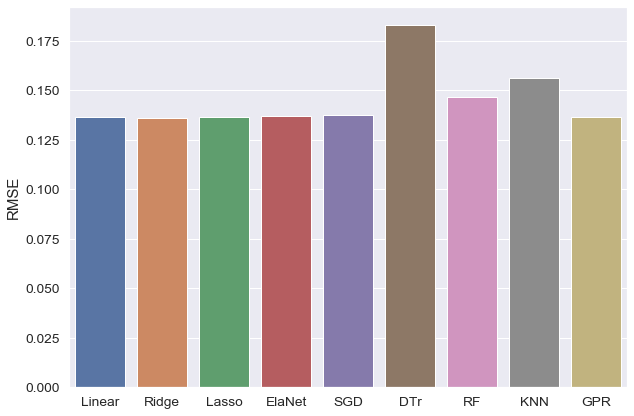

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()